In [13]:
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch([{'host':'uct2-es-door.mwt2.org', 'port':9200}])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle
plt.style.use('seaborn-paper')
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'



In [52]:
ind="stashcp-2016.9"

myquery1={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*a2gb*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1473252848028,
                  "lte": 1473309259064,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}


# Create total results list from es scroll

In [53]:
page= es.search(index=ind, body=myquery1, scroll='2m', search_type='scan', size=1)

sid = page['_scroll_id']

scroll_size = page['hits']['total']
results=[]

while (scroll_size > 0):
    page = es.scroll(scroll_id = sid, scroll = '2m')
    results.append(page['hits']['hits'])
    sid = page['_scroll_id']
    scroll_size = len(page['hits']['hits'])

scroll_size = page['hits']['total']
Res=[]
for i in range(0,scroll_size):
    Res.append(results[i][0]['_source'])
    
print(scroll_size)

19904


# Create dataframe from results

In [54]:
df = pd.DataFrame(Res)

del df['destination_space']
del df['xrdcp_version']
del df['download_size']
del df['filesize']
del df['IP']

begin=[]
for i in range(scroll_size):
    begin.append((int(df['timestamp'][i])-int(df['download_time'][i]))) #convert to minutes
    
df['begin']=begin
df=df.drop_duplicates(subset='start1', keep='last')
df=df.sort_values(by=['cache','start1'])
df = df[df['cache'] != '']
length=df.shape[0]
print(df.head(2))
print(list(df.columns.values))


                                                 cache  download_time  \
243  root://mwt2-stashcache.campuscluster.illinois.edu          52567   
234  root://mwt2-stashcache.campuscluster.illinois.edu          52213   

              end1  end2                         filename  \
243  1473261181574     0  user/taburaad/public/a2gb_1.tar   
234  1473261235212     0  user/taburaad/public/a2gb_1.tar   

                                                  host sitename  \
243  root://mwt2-stashcache.campuscluster.illinois.edu   osg-ce   
234  root://mwt2-stashcache.campuscluster.illinois.edu   osg-ce   

            start1  start2  start3   status      timestamp  tries  xrdexit1  \
243  1473261129007       0       0  Success  1473261181000      1         0   
234  1473261182999       0       0  Success  1473261235000      1         0   

     xrdexit2  xrdexit3          begin  
243        -1        -1  1473261128433  
234        -1        -1  1473261182787  
['cache', 'download_time', 'end1'

In [43]:
begin=int(df['begin'].iloc[1])//1000

for i in range(length):
    begin=int(df['begin'].iloc[i])//1000
    end=int(df['timestamp'].iloc[i])//1000
    start1=int(df['start1'].iloc[i])//1000
    end1=int(df['end1'].iloc[i])//1000
    start2=int(df['start2'].iloc[i])//1000
    end2=int(df['end2'].iloc[i])//1000
    start3=int(df['start3'].iloc[i])//1000
    df['begin'].iloc[i]=datetime.datetime.fromtimestamp(begin).strftime('%Y-%m-%d %H:%M:%S')
    df['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')  
    df['start1'].iloc[i]=datetime.datetime.fromtimestamp(start1).strftime('%Y-%m-%d %H:%M:%S')
    df['start2'].iloc[i]=datetime.datetime.fromtimestamp(start2).strftime('%Y-%m-%d %H:%M:%S')
    df['start3'].iloc[i]=datetime.datetime.fromtimestamp(start3).strftime('%Y-%m-%d %H:%M:%S')
    df['end1'].iloc[i]=datetime.datetime.fromtimestamp(end1).strftime('%Y-%m-%d %H:%M:%S')
    df['end2'].iloc[i]=datetime.datetime.fromtimestamp(end2).strftime('%Y-%m-%d %H:%M:%S')


    
df=df.set_index(['timestamp'])    
df.index = pd.to_datetime(df.index, unit='s')
df['begin']=pd.to_datetime(df['begin'], unit='s')
df['start1']=pd.to_datetime(df['start1'], unit='s')
df['start2']=pd.to_datetime(df['start2'], unit='s')
df['start3']=pd.to_datetime(df['start3'], unit='s')
df['end1']=pd.to_datetime(df.end1, unit='s')
df['end2']=pd.to_datetime(df.end2, unit='s')
#df.to_pickle('august25.pkl')
print ('done')

#with open('100.pkl', 'wb') as handle:
    #pickle.dump(df, handle, protocol=2)
print ('doneo')


done
doneo


In [44]:
df_UCSD=pd.DataFrame(columns=['cache', 'download_time', 'end1', 'end2', 'filename', 'host', 'sitename', 'start1', 'start2', 'start3', 'status', 'timestamp', 'tries', 'xrdexit1', 'xrdexit2', 'xrdexit3', 'begin'])
for i in range(length):
    if df.iloc[i,0]=='root://hcc-stash.unl.edu':
        df_UCSD=df_UCSD.append(df.iloc[[i]])

print(df_UCSD.head(2))
        
df_UCSD=df_UCSD.sort_values(by=['start1'])
df_UCSD['try']=0
df_UCSD
f=0
s=0
i=0
rates=[]
length2=df_UCSD.shape[0]
#print(df_UCSDT2.head(10))    
while i<length2:
    df_UCSD.iloc[i,17]=1
    df_UCSD.iloc[i+1,17]=2
    f=int(df_UCSD.iloc[i,2])
    s=int(df_UCSD.iloc[i+1,2])
    rates.append(s/f)
    i=i+2
    
#second / first try = speed-up
#df_UCSD_speedup=(s/f)
#print(df_UCSD_speedup)
print(rates)



                                  begin                     cache  \
2016-09-08 13:50:49 2016-09-08 13:50:30  root://hcc-stash.unl.edu   
2016-09-08 13:51:10 2016-09-08 13:50:50  root://hcc-stash.unl.edu   

                     download_time                end1                end2  \
2016-09-08 13:50:49        18137.0 2016-09-08 13:50:49 1969-12-31 18:00:00   
2016-09-08 13:51:10        19846.0 2016-09-08 13:51:10 1969-12-31 18:00:00   

                                            filename  \
2016-09-08 13:50:49  user/taburaad/public/a2gb_1.tar   
2016-09-08 13:51:10  user/taburaad/public/a2gb_1.tar   

                                         host sitename              start1  \
2016-09-08 13:50:49  root://hcc-stash.unl.edu      Red 2016-09-08 13:50:30   
2016-09-08 13:51:10  root://hcc-stash.unl.edu      Red 2016-09-08 13:50:50   

                                 start2              start3   status  \
2016-09-08 13:50:49 1969-12-31 18:00:00 1969-12-31 18:00:00  Success   
2016-09-0

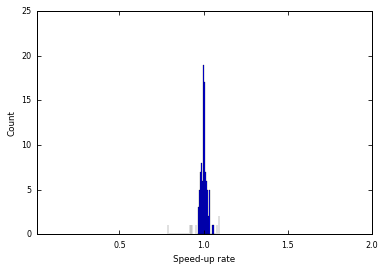

In [51]:
hist, bins = np.histogram(rates, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.axis([.01, 2, 0, 25])
plt.xlabel('Speed-up rate')
plt.ylabel('Count')
#plt.title('UNL Speed up rate frequency')
plt.show()



In [8]:
print(length)



8195


## function to calculate average time of second cache try over average time of first cache try (speed-up)

In [37]:
def speed_up(cache, yLim):
    columns=list(df.columns.values)
    df_cache=pd.DataFrame(columns=columns)
    for i in range(length):
        if df['cache'][i]==cache:
            df_cache=df_cache.append(df.iloc[[i]])
            
    df_cache=df_cache.sort_values(by=['start1'])
    df_cache['try']=0
    #print (df_site['host'].iloc[1])
    f=0
    s=0
    i=0
    length2=df_cache.shape[0]
    #print (length)
    #if (length%2==1):
        #df_cache=df_cache[:length-1]
    #length=df_cache.shape[0]
    rates2=[]
    #print (length)
    #print(df_site.head(100))
    while i<length2:
        df_cache['try'][i]=1
        df_cache['try'][i+1]=2
        f=int(df_cache['download_time'].iloc[i])
        s=int(df_cache['download_time'].iloc[i+1])
        rates2.append(s/f)
        i+=2
        
    hist, bins = np.histogram(rates2, bins=1500)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.axis([.01, 2, 0, yLim])
    plt.xlabel('Speed-up rate')
    plt.ylabel('Count')
    #plt.title('Origin Speed up rates')
    plt.show()

    #second / first try = speed-up
    #speedup=(s/f)
    #avg1=(f/length)/1000
    #avg2=(s/length)/1000
    #print("- speed up: %.2f, avg first try: %.2f sec, avg second try: %.2f sec using host %s" % (speedup, avg1, avg2, host))

#speed_up('root://xrd-cache-1.t2.ucsd.edu',300)

## Find speed up of each cache

UCSD:


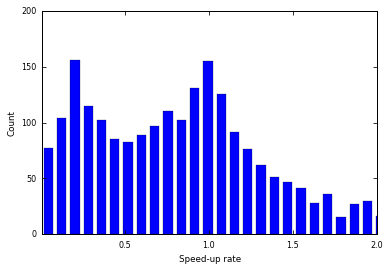

In [39]:
print("UCSD:")
speed_up('root://xrd-cache-1.t2.ucsd.edu',200)


Origin:


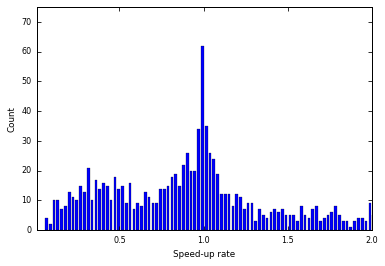

In [34]:
print("Origin:")
speed_up('root://stash.osgconnect.net',75)


BNL:


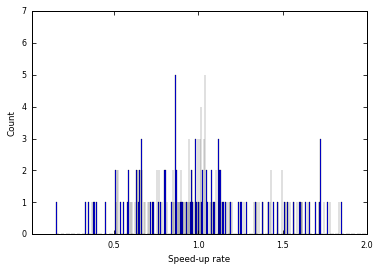

In [35]:
print("BNL:")
speed_up('root://osgxroot.usatlas.bnl.gov',7)
